# COVID-19 Open Research Dataset Challenge (CORD-19)
![](https://altaonline.typepad.com/.a/6a0192ac343706970d025d9b3673bb200c-800wi)

<h2>Goal</h2><br>
    This is my third response to the call to action to the artificial intelligence experts (if I can be called one) to develop text and data mining tools that can help the medical community develop answers to high priority scientific questions. For that I will use the CORD-19 dataset, which represents the most extensive machine-readable coronavirus literature collection available for data mining to date. Bellow are the current tasks for this challenge, which will be completed by the creation of a custer graph, a text classification for each cluster and a wordcloud for the main keywords for each cluster for the all_sources_metadata file. There are around 29500 papers in the dataset. These are listed in the all_sources_metadata file. Some of the papers in the metadata are also in JSON files. The eventual goal is to connect the metadata with the JSON data.<br>
    <h2>Tasks</h2>
    <ul>
    <li>What is known about transmission, incubation, and environmental stability?</li>
    <li>What do we know about COVID-19 risk factors?</li>
    <li>What do we know about virus genetics, origin, and evolution?</li>
    <li>Sample task with sample submission</li>
    <li>What do we know about vaccines and therapeutics?</li>
    <li>What do we know about non-pharmaceutical interventions?</li>
    <li>What has been published about ethical and social science considerations?</li>
    <li>What do we know about diagnostics and surveillance?</li>
    <li>What has been published about medical care?</li>
    <li>What has been published about information sharing and inter-sectoral collaboration?</li>
    </ul>
    <h2>Citations, ups and downs</h2><br>
    I tried to do this notebook by myself, which was terrifying. I was still looking forward to testing different NLP solutions (check my other ones <a href='https://www.kaggle.com/beatrizyumi/covid-19-autocomplete-search-bar'>here</a>  and here). I opted for the LDA, because it is easy to implement, has a visual output which is also easy to implement and it is possible to retrieve the main keywords and documents from each topic. On the plus side, you know exactly what each cluster is about, you get to see visualy the main keywords about each cluster, it is easy to implement. On the down side, I had zero experience with this sort of modeling and problem solving, which made the whole ordeal even longer to be solved, and depending on the size of the dataframe, it can take a while to load (mine took a few hours). Besides that I am still working on a way to split authors when they are separated by comma or by semicolon.<br>
    <h2>Features of this notebook</h2>
<ol><li>Viewing the papers in the metdata csv as a dataframe</li>
    <li>Viewing the papers separated by clusters in a graph</li>
    <li>Viewing the clusters listed and separated by topics</li>
    <li>Having a word cloud for each cluster with it's main keywords</li></ol>
    <h2>Turn your internet on!</h2><br>
    For this notebook to work your internet must be on.

# Importing libraries and datasets
![](https://media1.giphy.com/media/2yqYwtl5MUa6V405Ib/giphy.gif?cid=790b7611312b8226ba98603f316f4a2740c6e4a11ef228fc&rid=giphy.gif)

In [1]:
# Importing libraries

import sys
import os
from pathlib import Path
import re, numpy as np, pandas as pd
from pprint import pprint
import json
import glob

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# NLTK Stop words
import nltk
from nltk.corpus import stopwords

#plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [2]:
#loading metadata file

metadata_path = 'metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file
0,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license
1,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,custom_license
2,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,custom_license
3,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,custom_license
4,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,custom_license


In [3]:
# importing all json files

all_json = glob.glob(f'**/*.json', recursive=True)
len(all_json)

29315

# Treating the data
![](https://media2.giphy.com/media/l41YtBXZvSRdgqq7m/giphy.gif?cid=790b76115c16e4f50dc6c6525b7b74b67a0ef53415ae01c0&rid=giphy.gif)

First we create a class that will read the json files in a humane readable way.

In [4]:
# File Reader class

class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'

In [5]:
# Checking if the File Reader Class worked

print(FileReader(all_json[0]))

0015023cc06b5362d332b3baf348d11567ca2fbb: word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a si... VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 and P3 regions encode the non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro and 4 structura...


In [6]:
# Function to add break every length characters

def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

We then input all the json files into a DataFrame. (This might take a while, since there are a lot of files). A lot of things will happen here.<br><br>
<b>First</b> we will only work with papers with meta data.<br><br>
<b>Second</b> if there is no abstract provided, we will use the title of the research paper as the abstract, as the analysis will use the abstract as a basis.<br><br>
<b>Third</b> all the other information is included on it's field, separated if there is more than one of each, in the case of authors, for example.


In [7]:
# Input the research papers into a DataFrame

dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided, we input the title
        dict_['abstract_summary'].append(meta_data['title'].values[0])
    else:
        dict_['abstract_summary'].append(content.abstract)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    # if more than one author
    try:
        authors = str(meta_data['authors'].values[0]).split(';')
        authors1 = [i.split(',') for i in authors]    
        dict_['authors'].append(". ".join(authors))
    except Exception as e:
        dict_['authors'].append(". ".join(authors))
    
    # add the title information, add breaks when needed
    dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 29315
Processing index: 2931 of 29315
Processing index: 5862 of 29315
Processing index: 8793 of 29315
Processing index: 11724 of 29315
Processing index: 14655 of 29315
Processing index: 17586 of 29315
Processing index: 20517 of 29315
Processing index: 23448 of 29315
Processing index: 26379 of 29315
Processing index: 29310 of 29315


,paper_id,abstract,body_text,authors,title,journal,abstract_summary
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...","Ward, J. C. J.. Lasecka-Dykes, L.. Neil, C.....",The RNA pseudoknots in foot-and-mouth disease ...,NaN,word count: 194 22 Text word count: 5168 23 24...
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang. Kaichen Tang. Qin...,Healthcare-resource-adjusted vulnerabilities t...,NaN,Healthcare-resource-adjusted vulnerabilities t...
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...","Butt, S. L.. Erwood, E. C.. Zhang, J.. Sell...","Real-time, MinION-based, amplicon sequencing f...",NaN,Infectious bronchitis (IB) causes significant ...
3,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay. Kishan Kalia. ...,A Combined Evidence Approach to Prioritize Nip...,NaN,Nipah Virus (NiV) came into limelight recently...
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...,"In December 2019, a cluster of patients with p...",Shengjie Lai. Isaac Bogoch. Nick Ruktanoncha...,Assessing spread risk of Wuhan novel coronavir...,NaN,Background: A novel coronavirus (2019-nCoV) em...


In [8]:
dict_ = None

In [9]:
# Adding word count column

df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...","Ward, J. C. J.. Lasecka-Dykes, L.. Neil, C.....",The RNA pseudoknots in foot-and-mouth disease ...,NaN,word count: 194 22 Text word count: 5168 23 24...,241,1728
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang. Kaichen Tang. Qin...,Healthcare-resource-adjusted vulnerabilities t...,NaN,Healthcare-resource-adjusted vulnerabilities t...,0,755
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...","Butt, S. L.. Erwood, E. C.. Zhang, J.. Sell...","Real-time, MinION-based, amplicon sequencing f...",NaN,Infectious bronchitis (IB) causes significant ...,1647,4003
3,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay. Kishan Kalia. ...,A Combined Evidence Approach to Prioritize Nip...,NaN,Nipah Virus (NiV) came into limelight recently...,326,2399
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...,"In December 2019, a cluster of patients with p...",Shengjie Lai. Isaac Bogoch. Nick Ruktanoncha...,Assessing spread risk of Wuhan novel coronavir...,NaN,Background: A novel coronavirus (2019-nCoV) em...,22,4642


There may be papers that were inputted from more than one source, so we should check and remove duplicated inputs.

In [10]:
# We will remove the duplicated papers
df_covid.shape

(27678, 9)

In [11]:
# Removing duplicated papers

duplicate_paper = ~(df_covid.title.isnull() | df_covid.abstract.isnull()) & (df_covid.duplicated(subset=['title', 'abstract']))
df_covid = df_covid[~duplicate_paper].reset_index(drop=True)
df_covid.shape

(27425, 9)

We will now start treating the text inside the DataFrame. Before doing anything, we have to define a lot of functions to do that.

In [12]:
# Creating a function that cleans text of special characters

def strip_characters(text):
    t = re.sub('\(|\)|:|,|;|\.|’|”|“|\?|%|>|<', '', text)
    t = re.sub('/', ' ', t)
    t = t.replace("'",'')
    return t

<>:4: DeprecationWarning: invalid escape sequence \(
<>:4: DeprecationWarning: invalid escape sequence \(
<>:4: DeprecationWarning: invalid escape sequence \(
<ipython-input-12-b498eeac4b3b>:4: DeprecationWarning: invalid escape sequence \(
  t = re.sub('\(|\)|:|,|;|\.|’|”|“|\?|%|>|<', '', text)


In [13]:
# Creating a function that makes text lowercase and uses the function created above

def clean(text):
    t = text.lower()
    t = strip_characters(t)
    return t

In [14]:
# Tokenize into individual tokens - words mostly

def tokenize(text):
    words = nltk.word_tokenize(text)
    return list(set([word for word in words 
                     if len(word) > 1
                     and not (word.isnumeric() and len(word) is not 4)
                     and (not word.isnumeric() or word.isalpha())] )
               )

In [15]:
# Creating a function that cleans and tokenize texts

def preprocess(text):
    t = clean(text)
    tokens = tokenize(t)
    return tokens

We will now tokenize the abstract and transform the output into a list.

In [16]:
# Preprocessing all the strings inside the column abstract. It will clean them, make them lower case and tokenize them.

df_covid['abstract_processed'] = df_covid['abstract'].apply(lambda x: preprocess(x))

In [17]:
# Transforming abstract_processed into a list

abstract = list(df_covid['abstract_processed'])
print(abstract[:1])

[['rights', 'five', 'pk', 'text', 'describing', 'genomes', 'presence', 'internal', 'were', 'initiation', 'author', 'packaging', 'pseudoknots', 'by', 'function', 'ires', 'putative', 'report', 'confirmed', 'reuse', 'count', 'reading', 'length', 'utrs', 'these', 'flanked', 'virus', 'include', 'that', 'untranslated', 'less', 'is', 'earlier', 'poly-c-tract', 'was', 'without', 'signals', 'has', 'primer', 'advantage', 'site', 'genome', 'nucleotides', 'containing', 'acetylation', 'analysed', 'pks', 'deletion', 'unusually', 'terminal', 'replication', 'selective', 'they', 'variable', 'investigated', 'not', '2′', 'rescued', 'no', 'disease', 'one', 'cre', 'region', 'element', 'importance', 'permission', 'consistent', 'from', 'positive', 'than', 'allowed', 'reserved', 'translation', 'are', 'abstract', 'mutation', 'and', 'shape', '3′', 'provide', 'with', 'regions', 'four', 'their', 'previously', 'repeated', 'in', 'however', 'foot-and-mouth', 'although', 'competent', 'word', 'replicons', 'fmdv', 'utr

We will now create a bigram and a trigram models and lemmetize.

In [18]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(abstract, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[abstract], threshold=100)  
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [19]:
# Creating a list of stopwords in english

stop_words = list(set(stopwords.words('english')))
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [20]:
# Creating a function that will remove stopwords, form bigrams, form tigrams and lemmatize

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [21]:
# Processing the abstract

abstract_processed = process_words(abstract)

# It is time for some modeling
![](https://media0.giphy.com/media/Mvm1XBC8O48EM/giphy.gif?cid=790b76119bdd3e0bcedc198f7b26c76abecbb392aba651cf&rid=giphy.gif)

But first let's create a dictionary and a corpus

In [22]:
# Creating the dictionary

id2word = corpora.Dictionary(abstract_processed)

In [23]:
# Create Corpus: Term Document Frequency

corpus = [id2word.doc2bow(text) for text in abstract_processed]

In [24]:
from gensim.models.ldamulticore import LdaMulticore

In [25]:
lda = LdaMulticore(corpus, id2word=id2word, num_topics=26)

In [26]:
# Defining the best number of topics for the LDA model

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=26)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=abstract_processed, start=2, limit=100, step=6)

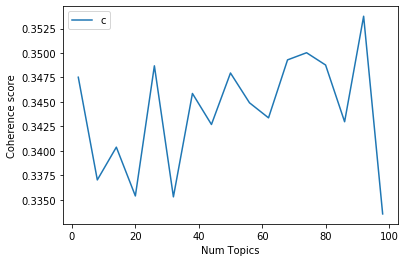

In [28]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3475
Num Topics = 8  has Coherence Value of 0.337
Num Topics = 14  has Coherence Value of 0.3404
Num Topics = 20  has Coherence Value of 0.3354
Num Topics = 26  has Coherence Value of 0.3487
Num Topics = 32  has Coherence Value of 0.3353
Num Topics = 38  has Coherence Value of 0.3459
Num Topics = 44  has Coherence Value of 0.3427
Num Topics = 50  has Coherence Value of 0.348
Num Topics = 56  has Coherence Value of 0.3449
Num Topics = 62  has Coherence Value of 0.3434
Num Topics = 68  has Coherence Value of 0.3493
Num Topics = 74  has Coherence Value of 0.35
Num Topics = 80  has Coherence Value of 0.3488
Num Topics = 86  has Coherence Value of 0.343
Num Topics = 92  has Coherence Value of 0.3538
Num Topics = 98  has Coherence Value of 0.3335


The highest Coherence value was with 26 topics before flattening out, so we will go with 20.

In [30]:
# Build LDA model

lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=20, 
                        random_state=42,
                        chunksize=150,
                        passes=30,
                        iterations = 500,
                        per_word_topics=True)

In [31]:
# Compute Perplexity (lower = better)

print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -8.837836500996783


In [32]:
# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=abstract_processed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.44789317739713735


In [33]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.105124 -0.093294       1        1  10.808334
15    -0.130903  0.092011       2        1  10.223303
8     -0.150474 -0.042035       3        1   9.510209
3     -0.160394  0.012739       4        1   8.369339
1     -0.078321 -0.018186       5        1   8.120233
17    -0.110074  0.136712       6        1   8.049628
16    -0.128884  0.016099       7        1   7.297338
0     -0.099925 -0.057941       8        1   6.872532
7     -0.087326 -0.129745       9        1   5.728505
2     -0.092578  0.236629      10        1   4.526489
11    -0.051852  0.202497      11        1   3.839947
12     0.018054 -0.129523      12        1   3.337859
9     -0.069254  0.017381      13        1   3.308566
4     -0.002597 -0.076271      14        1   2.649562
13     0.019324 -0.123793      15        1   1.958418
14     0.150845 -0.025559      16        1   1.848955
5      0.123586 -0.234260      17        1   1.782559
19     0.293608  0.117169      18        1   0.865381
18     0.325190  0.034795      19        1   0.568211
6      0.337098  0.064572      20        1   0.334629, topic_info=               Term          Freq         Total Category  logprob  loglift
364        sequence   3850.000000   3850.000000  Default  30.0000  30.0000
84            virus  13864.000000  13864.000000  Default  29.0000  29.0000
350     respiratory   4666.000000   4666.000000  Default  28.0000  28.0000
635            cell  10281.000000  10281.000000  Default  27.0000  27.0000
4          analysis   5022.000000   5022.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
3353       nowadays     31.240343     32.388397  Topic20  -5.1295   5.6638
1350         centre    125.766190    179.675537  Topic20  -3.7368   5.3432
1621   organization    104.387146    461.164154  Topic20  -3.9231   4.2143
2512  contamination     72.817940    220.732513  Topic20  -4.2833   4.5909
1995          breed     62.897366    159.299210  Topic20  -4.4297   4.7706

[1364 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3508     12  0.986676   abdominal
4937      3  0.988478    abrogate
3252      2  0.436987    academic
3252     18  0.559155    academic
5552     12  0.983946  acceptable
...     ...       ...         ...
1648      8  0.227546       yield
1648      9  0.027489       yield
1648     17  0.386371       yield
3672     10  0.987243    zoonosis
802      10  0.997352    zoonotic

[3145 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 16, 9, 4, 2, 18, 17, 1, 8, 3, 12, 13, 10, 5, 14, 15, 6, 20, 19, 7])

In [34]:
# Select the model and print the topics

optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(6,
  '0.011*"study" + 0.009*"infection" + 0.008*"result" + 0.008*"virus" + '
  '0.005*"high" + 0.005*"human" + 0.005*"show" + 0.004*"identify" + '
  '0.004*"cause" + 0.004*"respiratory"'),
 (11,
  '0.009*"infection" + 0.007*"study" + 0.006*"identify" + 0.006*"include" + '
  '0.006*"result" + 0.005*"human" + 0.005*"cause" + 0.004*"report" + '
  '0.004*"increase" + 0.004*"protein"'),
 (25,
  '0.009*"result" + 0.007*"method" + 0.007*"virus" + 0.007*"study" + '
  '0.007*"disease" + 0.005*"high" + 0.005*"base" + 0.005*"patient" + '
  '0.005*"include" + 0.005*"infection"'),
 (3,
  '0.013*"infection" + 0.007*"virus" + 0.006*"report" + 0.005*"study" + '
  '0.005*"result" + 0.005*"include" + 0.004*"base" + 0.004*"control" + '
  '0.004*"patient" + 0.004*"outbreak"'),
 (5,
  '0.009*"virus" + 0.006*"result" + 0.006*"infection" + 0.005*"cell" + '
  '0.005*"case" + 0.005*"study" + 0.005*"human" + 0.005*"disease" + '
  '0.005*"include" + 0.005*"response"'),
 (4,
  '0.018*"virus" + 0.007*"result" + 

In [35]:
# Find the dominant topic in each sentence

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=abstract_processed):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [36]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=abstract_processed)

In [37]:
# Format

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [38]:
# Show

df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.7928,"virus, result, study, protein, viral, cell, sh...","[text, describe, genome, presence, internal, i..."
1,1,0.0,0.0385,"cell, infection, virus, study, result, induce,...",[]
2,2,25.0,0.5342,"result, method, virus, study, disease, high, b...","[pool, veterinary, author, problem, sequence, ..."
3,3,25.0,0.4355,"result, method, virus, study, disease, high, b...","[community, severe, screen, curation, force, b..."
4,4,3.0,0.5639,"infection, virus, report, study, result, inclu...","[coronavirus, emerge, novel, cause, outbreak]"
5,5,16.0,0.8075,"disease, health, human, model, virus, public, ...","[source, build, interface, add, gene, perspect..."
6,6,21.0,0.6648,"cell, protein, virus, study, bind, show, ident...","[constraint, thousand, hijack, hundred, mammal..."
7,7,16.0,0.7916,"disease, health, human, model, virus, public, ...","[holiday, associate, lead, however, community,..."
8,8,4.0,0.5018,"virus, result, study, protein, viral, cell, sh...","[involve, nanotube, gene, direct, develop, app..."
9,9,0.0,0.0385,"cell, infection, virus, study, result, induce,...",[]


In [45]:
df_dominant_topic.shape

(27425, 5)

In [42]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9949,"cell, infection, virus, study, result, induce,...","[ratio, cell, upregulate, inhibitory, degenera..."
1,1.0,0.9928,"virus, cell, study, infection, protein, respon...","[presence, reveal, lifecycle, review, intimate..."
2,2.0,0.9885,"cell, study, show, activity, increase, include...","[interest, presence, prompt, different, antipy..."
3,3.0,0.9882,"infection, virus, report, study, result, inclu...","[source, ratio, facility, intervention, cross,..."
4,4.0,0.9950,"virus, result, study, protein, viral, cell, sh...","[frame, reveal, assess, mechanism, relevant, p..."
5,5.0,0.9909,"virus, result, infection, cell, case, study, h...","[weigh, calcium, mucin, palate, assess, partic..."
6,6.0,0.9917,"study, infection, result, virus, high, human, ...","[cross, purchase, county, different, assess, r..."
7,7.0,0.9933,"study, cell, result, virus, protein, high, inf...","[utilize, sign, dose, depletion, cell, mother,..."
8,8.0,0.9953,"virus, protein, system, review, disease, study...","[release, extended, length, nanoparticle, body..."
9,9.0,0.9918,"study, cell, show, time, disease, base, result...","[dataset, network, advancement, train, questio..."


In [44]:
# extracting keywords per topic

keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]
keywords.to_csv('keywords.csv')

In [40]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,4.0,"virus, result, study, protein, viral, cell, sh...",9826.0,0.3583
1.0,0.0,"cell, infection, virus, study, result, induce,...",595.0,0.0217
2.0,25.0,"result, method, virus, study, disease, high, b...",228.0,0.0083
3.0,25.0,"result, method, virus, study, disease, high, b...",165.0,0.0060
4.0,3.0,"infection, virus, report, study, result, inclu...",2396.0,0.0874
...,...,...,...,...
27420.0,14.0,"virus, cell, show, protein, study, result, inf...",NaN,NaN
27421.0,24.0,"infection, virus, patient, respiratory, study,...",NaN,NaN
27422.0,19.0,"virus, infection, cell, result, study, day, in...",NaN,NaN
27423.0,21.0,"cell, protein, virus, study, bind, show, ident...",NaN,NaN


In [46]:
# extracting dominant topics

df_dominant_topics.to_csv('topic_keyword_document.csv')

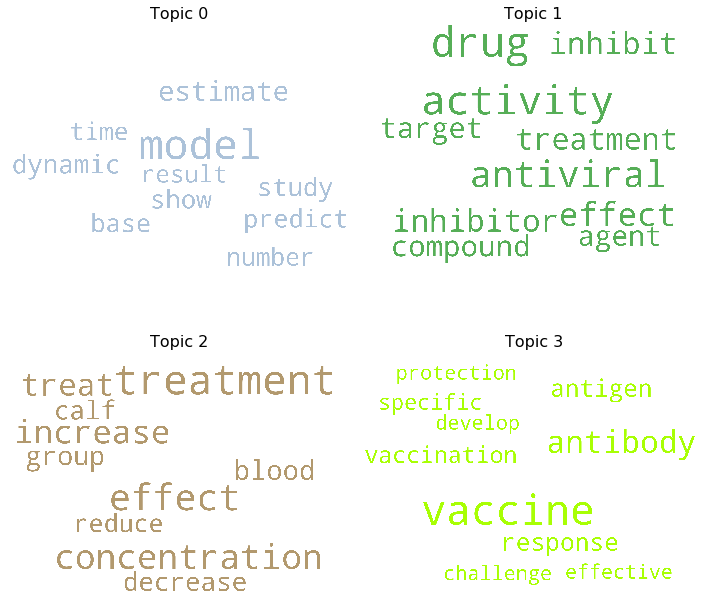

In [41]:
# Creating word clouds for each topic

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()